# Programa Ingenias+ Data Science

## Objetivo del notebook

El objetivo de este notebook es aplicar y comparar técnicas de aprendizaje no supervisado, tanto de clustering como de reducción de dimensionalidad, para identificar patrones y estructuras subyacentes en los datos.

Las columnas de características que se utilizarán en el notebook se detallan a continuación.


## Importación de archivos y librerías

In [1]:
# Imports de librerías y funciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from utils.codificaciones import *
from utils.funcions import *

In [2]:
# Importar el csv
friesgo_raw = pd.read_csv('datasets/friesgo.csv')

In [3]:
friesgo_raw2 = pd.read_csv('datasets/friesgo_analisis.csv')

In [4]:
friesgo_raw2.shape

(29224, 44)

## Preprocesado

### Identificación de variables

In [5]:
columnas_presentes = {
    'cod_provincia', 'tamanio_aglomerado', 'submuestra', 'sexo', 'edad', 'situacion_conyugal', 'nivel_educ', 'cobertura_salud', 
    'condicion_actividad', 'consumo_sal', 'ranking_dieta', 'media_fv_diaria', 'medido_colesterol', 'colesterol_alto', 
    'tratamiento_medico_col', 'freq_cons_alc', 'tipo_bebida', 'af_intensa_veces_por_semana', 'af_moderada_veces_por_semana', 
    'caminata_veces_por_semana', 'tiempo_sentado_min_por_dia', 'nivel_actividad_fisica', 'barreras_actividad_fisica', 
    'salud_actual', 'nivel_de_movilidad', 'capacidad_cuidado_personal', 'capacidad_actividades_cotidianas', 'dolor_malestar_general', 
    'ansiedad_depresion', 'peso_autoreportado_kg', 'altura_autoreportado_cm', 'imc_autoreportado', 'imc_categorias_autoreportado', 
    'condicion_fumador', 'fumado_100_cigarrillos', 'periodicidad_fumador', 'cant_tipos_tabaco', 'es_diabetico', 
    'ultima_medicion_glucemia', 'presion_arterial_elevada', 'imc_categoria', 'diagnostico_cosanguineos'
}

In [8]:
# Copiar el dataframe
friesgo_cod = friesgo_raw2.copy()

In [9]:
friesgo_cod.shape

(29224, 44)

### Evaluación y procesamiento de nulos

In [10]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
consumo_sal,0,0.0%
tratamiento_medico_col,22841,78.16%
media_fv_diaria,753,2.58%
caminata_veces_por_semana,0,0.0%
peso_autoreportado_kg,1011,3.46%
imc_categoria,12647,43.28%
fumado_100_cigarrillos,0,0.0%
capacidad_cuidado_personal,0,0.0%
nivel_de_movilidad,0,0.0%
ranking_dieta,0,0.0%


In [11]:
# Eliminación de nulos aun NO
#friesgo_cod = friesgo_cod.dropna()

In [12]:
friesgo_cod.shape

(29224, 44)

### Codificación de columnas

In [13]:
# Codificación de columnas
le = LabelEncoder()
for columnas in friesgo_cod:
    friesgo_cod[columnas] = le.fit_transform(friesgo_cod[columnas])

In [14]:
# Evaluar que no haya pérdida de filas y/o columnas por la codificación
friesgo_cod.shape

(29224, 44)

friesgo_reducida = friesgo_cod.filter(items=[ 'diagnostico_cosanguineos',
    'cobertura_salud',
    'nivel_de_movilidad',
    'ultima_medicion_glucemia',
    'presion_arterial_elevada',
    'dolor_malestar_general',
    'medido_colesterol',
    'tratamiento_medico_col',
    'consumo_sal',
    'colesterol_alto',
    'salud_actual',
    'edad',
    'mantiene_ha_alta'])

In [15]:
friesgo_reducida = friesgo_cod.filter(items=[ 'diagnostico_cosanguineos',
    'cobertura_salud',
    'nivel_de_movilidad',
    'ultima_medicion_glucemia',
    'presion_arterial_elevada',
    'dolor_malestar_general',
    'medido_colesterol',
    'tratamiento_medico_col',
    'consumo_sal',
    'colesterol_alto',
    'salud_actual',
    'edad',
    'mantiene_ha_alta'])
calcular_nulos_y_porcentaje(friesgo_reducida)

,Nulos,Porcentaje
diagnostico_cosanguineos,0,0.0%
cobertura_salud,0,0.0%
nivel_de_movilidad,0,0.0%
ultima_medicion_glucemia,0,0.0%
presion_arterial_elevada,0,0.0%
dolor_malestar_general,0,0.0%
medido_colesterol,0,0.0%
tratamiento_medico_col,0,0.0%
consumo_sal,0,0.0%
colesterol_alto,0,0.0%


## Reduccion de dimensionalidad

### Metodo Manual : Permutation importance

Se aplicara un algoritmo de clasificacion Random forest para sobre este poder medir la importancia de las caracteristicas/features/columnas del dataset para decidir cuales son las mas importantes para posteriormente realizar una reduccion de dimensionalidad eliminando las columnas cuyas importancias esten representadas por porcentajes bajos.

In [16]:
# Separo los conjuntos para entrenamiento y testeo
y = friesgo_cod['mantiene_ha_alta']
X = friesgo_cod.drop(columns=['mantiene_ha_alta'])
X_train_pi, X_test_pi, y_train_pi, y_test_pi = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
# Entreno el modelo para tener los parametros de accuracy de base
modelo = RandomForestClassifier(random_state=42,criterion= 'gini', n_estimators=200, max_depth=8)
# Ajusto el modelo
modelo.fit(X_train_pi, y_train_pi)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [18]:
# Calculo el acurracy base
y_pred_pi = modelo.predict(X_test_pi)
acc = accuracy_score(y_test_pi, y_pred_pi)
acc

0.6629790145985401

In [19]:
# Calculo Permutation Importance
perm = permutation_importance(modelo, X_test_pi, y_test_pi,random_state=1)

In [20]:
# Ordeno las caracteristicas por importancia promedio
indices = np.argsort(perm.importances_mean)[::-1]  # Orden descendente
features = X_test_pi.columns[indices]
importances = perm.importances_mean[indices]
importances_std = perm.importances_std[indices]

In [21]:
features

Index(['edad', 'salud_actual', 'colesterol_alto', 'presion_arterial_elevada',
       'consumo_sal', 'medido_colesterol', 'es_diabetico',
       'tratamiento_medico_col', 'dolor_malestar_general',
       'ultima_medicion_glucemia', 'imc_numerico',
       'capacidad_actividades_cotidianas', 'cobertura_salud',
       'nivel_actividad_fisica', 'ansiedad_depresion', 'tipo_bebida',
       'nivel_de_movilidad', 'diagnostico_cosanguineos',
       'barreras_actividad_fisica', 'capacidad_cuidado_personal',
       'ranking_dieta', 'condicion_fumador', 'fumado_100_cigarrillos',
       'cod_provincia', 'altura_autoreportado_cm', 'cant_tipos_tabaco',
       'submuestra', 'af_intensa_veces_por_semana', 'sexo',
       'tamanio_aglomerado', 'periodicidad_fumador',
       'af_moderada_veces_por_semana', 'condicion_actividad', 'freq_cons_alc',
       'caminata_veces_por_semana', 'tiempo_sentado_min_por_dia',
       'peso_autoreportado_kg', 'media_fv_diaria',
       'imc_categorias_autoreportado', 'imc_ca

In [22]:
importances

array([ 3.29607664e-02,  6.82025547e-03,  2.44069343e-03,  2.39507299e-03,
        2.12135036e-03,  1.96167883e-03,  1.59671533e-03,  1.59671533e-03,
        1.57390511e-03,  1.52828467e-03,  9.35218978e-04,  8.21167883e-04,
        6.38686131e-04,  4.79014599e-04,  4.10583942e-04,  4.10583942e-04,
        3.19343066e-04,  2.73722628e-04,  2.50912409e-04,  1.59671533e-04,
        1.36861314e-04,  1.36861314e-04,  1.14051095e-04,  4.56204380e-05,
        2.28102190e-05,  2.28102190e-05, -9.12408759e-05, -1.14051095e-04,
       -1.36861314e-04, -1.59671533e-04, -1.82481752e-04, -2.05291971e-04,
       -2.96532847e-04, -4.10583942e-04, -4.56204380e-04, -5.01824818e-04,
       -5.47445255e-04, -5.70255474e-04, -7.29927007e-04, -8.89598540e-04,
       -8.89598540e-04, -9.35218978e-04, -1.43704380e-03])

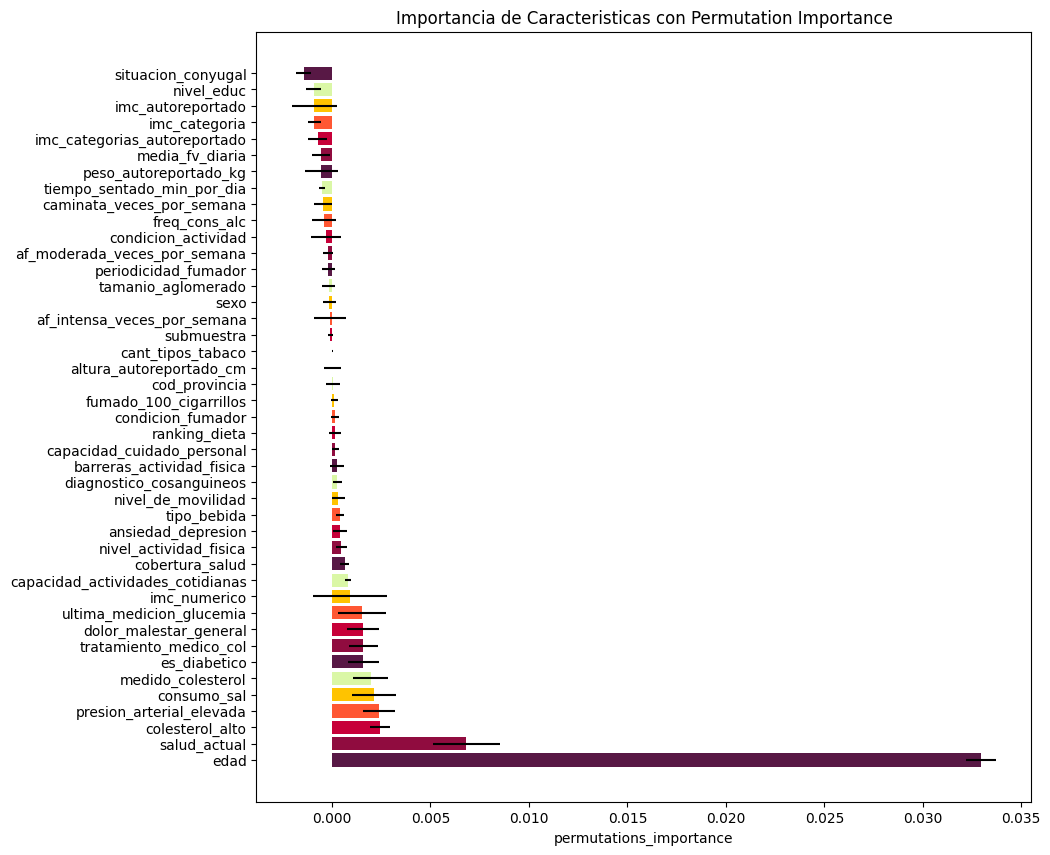

In [23]:
# Creo el gráfico de barras
plt.figure(figsize=(10, 10))
plt.barh(features, importances, xerr=importances_std, align='center',color=['#581845','#900C3F','#C70039','#FF5733','#FFC300','#DAF7A6'])
plt.xlabel('permutations_importance')
plt.title('Importancia de Caracteristicas con Permutation Importance')
plt.show()

In [24]:
friesgo_reducida = friesgo_cod.filter(items=[ 'diagnostico_cosanguineos',
    'cobertura_salud',
    'nivel_de_movilidad',
    'ultima_medicion_glucemia',
    'presion_arterial_elevada',
    'dolor_malestar_general',
    'medido_colesterol',
    'tratamiento_medico_col',
    'consumo_sal',
    'colesterol_alto',
    'salud_actual',
    'edad'])

### Metodo por Algoritmo No Supervisado

### Estandarizar datos

PCA es sensible a la escala de las columnas. La estandarización asegura que cada característica contribuya igualmente al análisis.

In [ ]:
# Estandarización de los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(friesgo_cod)

### Evaluar el número óptimo de componentes para PCA

Para conservar el 95% de información al aplicar PCA, hay que seleccionar el número de componentes principales que en conjunto expliquen al menos el 95% de la varianza total.

In [ ]:
pca = PCA(n_components = 0.95)
pca_data = pca.fit_transform(scaled_data)
n_components = pca.n_components_

# Ver el número de componentes seleccionados automáticamente
print(f"Número de componentes seleccionados: {n_components}")

Número de componentes seleccionados: 14


### Aplicar PCA 

Para conservar el 95% de información al aplicar PCA, hay que seleccionar el número de componentes principales que en conjunto expliquen al menos el 95% de la varianza total.

In [ ]:
# Aplicar PCA con el número óptimo de componentes
pca_opt = PCA(n_components = n_components)
pca_opt_data = pca_opt.fit_transform(scaled_data)

# Convertir a DataFrame para facilitar el manejo
pca_df = pd.DataFrame(data = pca_opt_data, columns = [f'PC{i+1}' for i in range(n_components)])

### Visualizar la varianza explicada 

Permite ver cómo cada componente principal contribuye a la varianza total y cómo se acumula la varianza explicada.

In [ ]:
# Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Imprimir la varianza explicada por cada componente principal
print('Varianza explicada')
for i in range(n_components):
    print('PC{}: {}'.format(i+1, pca.explained_variance_ratio_[i]))

Varianza explicada
PC1: 0.15556035687712857
PC2: 0.09267600381227904
PC3: 0.0896310891536627
PC4: 0.07784959576674855
PC5: 0.06898888886702716
PC6: 0.06411838031114755
PC7: 0.060503448413836425
PC8: 0.056894984375953056
PC9: 0.05504170396580302
PC10: 0.053452053314127924
PC11: 0.05190839933107017
PC12: 0.049530084060620726
PC13: 0.04708515673377828
PC14: 0.04337426475990944


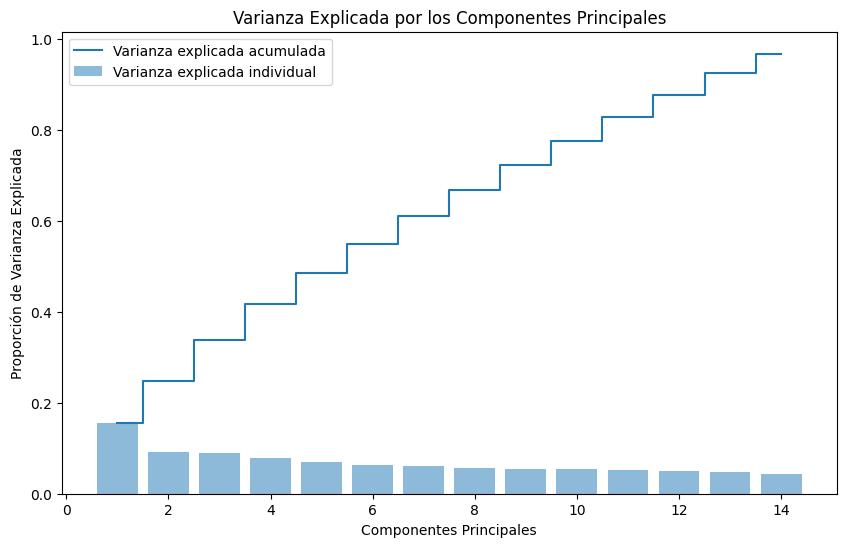

In [ ]:
# Visualización de la varianza explicada por cada componente
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Varianza explicada individual')
plt.step(range(1, len(np.cumsum(explained_variance)) + 1), np.cumsum(explained_variance), where='mid', label='Varianza explicada acumulada')
plt.xlabel('Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Varianza Explicada por los Componentes Principales')
plt.legend(loc='best')
plt.show()

## Análisis de modelos

### Modelo 1: K-Means

In [ ]:
# test codo

### Modelo 2: DBSCAN